In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  


In [2]:
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)


(True, 'NVIDIA GeForce RTX 2080 Ti')

In [3]:
from pathlib import Path
import soundfile as sf
import pandas as pd

session_dir = Path("/scratch/users/arunps/hindibabynet/audio_raw/ABAN141223/20250216")
wav_files = sorted(session_dir.glob("*.WAV")) + sorted(session_dir.glob("*.wav"))
wav_path = wav_files[0]
info = sf.info(str(wav_path))
print(wav_path.name, info.samplerate, info.channels, info.duration/3600, "hours")


1739683525.WAV 16000 1 4.983338888888889 hours


In [4]:
import soundfile as sf
import pandas as pd

rows = []
for p in wav_files:
    info = sf.info(str(p))
    rows.append({
        "participant_id": "ABAN141223",
        "session_date": "20250216",
        "recording_id": p.stem,
        "path": str(p),
        "duration_sec": float(info.duration),
        "sample_rate": int(info.samplerate),
        "channels": int(info.channels),
        "size_bytes": p.stat().st_size,
    })

recordings = pd.DataFrame(rows)
recordings


,participant_id,session_date,recording_id,path,duration_sec,sample_rate,channels,size_bytes
0,ABAN141223,20250216,1739683525,/scratch/users/arunps/hindibabynet/audio_raw/A...,17940.02,16000,1,574081152
1,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/A...,7331.10,16000,1,234595712


In [5]:
import webrtcvad
import numpy as np
import soundfile as sf

def webrtc_vad_regions(path, aggressiveness=2, frame_ms=30, min_region_ms=300):
    vad = webrtcvad.Vad(aggressiveness)

    audio, sr = sf.read(str(path), dtype="int16")
    if audio.ndim == 2:
        audio = audio[:, 0]  # take channel 0

    # WebRTC supports only these sample rates
    if sr not in (8000, 16000, 32000, 48000):
        raise ValueError(f"webrtcvad needs sr in (8k,16k,32k,48k). got: {sr}")

    frame_len = int(sr * frame_ms / 1000)
    n_frames = len(audio) // frame_len

    speech = []
    for i in range(n_frames):
        frame = audio[i*frame_len:(i+1)*frame_len]
        if len(frame) < frame_len:
            break
        speech.append(vad.is_speech(frame.tobytes(), sr))

    # Merge consecutive speech frames
    regions = []
    in_speech = False
    start_i = 0
    for i, is_speech in enumerate(speech):
        if is_speech and not in_speech:
            in_speech = True
            start_i = i
        elif (not is_speech) and in_speech:
            in_speech = False
            end_i = i
            regions.append((start_i, end_i))

    if in_speech:
        regions.append((start_i, len(speech)))

    # seconds + filter
    out = []
    for s_i, e_i in regions:
        s = (s_i * frame_len) / sr
        e = (e_i * frame_len) / sr
        if (e - s) * 1000 >= min_region_ms:
            out.append((s, e))
    return out

regions = webrtc_vad_regions(wav_path, aggressiveness=2)
len(regions), regions[:5]


(5403,
 [(0.0, 1.11), (1.2, 14.64), (14.73, 40.8), (40.86, 66.48), (66.51, 66.9)])

In [6]:
vad_df = pd.DataFrame([{
    "participant_id": "ABAN141223",
    "session_date": "20250216",
    "recording_id": wav_path.stem,
    "wav_path": str(wav_path),
    "start_sec": s,
    "end_sec": e,
    "duration_sec": e - s,
} for s, e in regions])

In [7]:
vad_df

,participant_id,session_date,recording_id,wav_path,start_sec,end_sec,duration_sec
0,ABAN141223,20250216,1739683525,/scratch/users/arunps/hindibabynet/audio_raw/A...,0.00,1.11,1.11
1,ABAN141223,20250216,1739683525,/scratch/users/arunps/hindibabynet/audio_raw/A...,1.20,14.64,13.44
2,ABAN141223,20250216,1739683525,/scratch/users/arunps/hindibabynet/audio_raw/A...,14.73,40.80,26.07
3,ABAN141223,20250216,1739683525,/scratch/users/arunps/hindibabynet/audio_raw/A...,40.86,66.48,25.62
4,ABAN141223,20250216,1739683525,/scratch/users/arunps/hindibabynet/audio_raw/A...,66.51,66.90,0.39
...,...,...,...,...,...,...,...
5398,ABAN141223,20250216,1739683525,/scratch/users/arunps/hindibabynet/audio_raw/A...,17918.82,17920.86,2.04
5399,ABAN141223,20250216,1739683525,/scratch/users/arunps/hindibabynet/audio_raw/A...,17921.91,17922.36,0.45
5400,ABAN141223,20250216,1739683525,/scratch/users/arunps/hindibabynet/audio_raw/A...,17925.03,17925.54,0.51
5401,ABAN141223,20250216,1739683525,/scratch/users/arunps/hindibabynet/audio_raw/A...,17926.47,17927.49,1.02


In [8]:
import os
os.environ["PYANNOTE_DISABLE_NOTEBOOK"] = "1"

import matplotlib
matplotlib.use("Agg")

In [9]:
from dotenv import load_dotenv
import os

load_dotenv()  

assert os.getenv("HF_TOKEN") is not None, "HF_TOKEN not loaded"
print("HF_TOKEN loaded")

HF_TOKEN loaded


In [10]:
import os

scratch_cache = f"/scratch/users/{os.environ['USER']}/.cache/huggingface"
os.environ["HF_HOME"] = scratch_cache
os.environ["HF_HUB_CACHE"] = f"{scratch_cache}/hub"
os.environ["TRANSFORMERS_CACHE"] = f"{scratch_cache}/transformers"


In [11]:
import torch
from pyannote.audio import Pipeline

pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token=os.environ["HF_TOKEN"]
)

pipeline.to(torch.device("cuda"))
print("Pipeline loaded on GPU")


/itf-fi-ml/home/arunps/Projects/HindiBabyNet/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/itf-fi-ml/home/arunps/Projects/HindiBabyNet/.venv/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:73: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowliste

Pipeline loaded on GPU


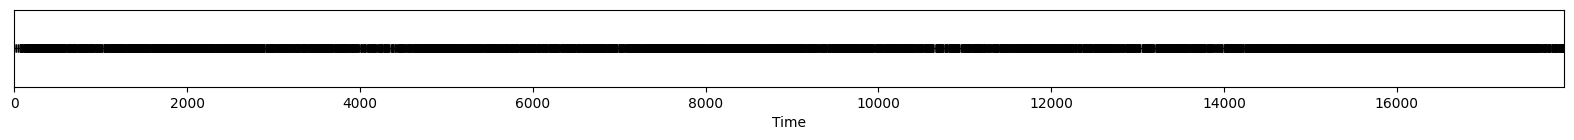

In [12]:
from pyannote.core import Segment, Timeline

speech_timeline = Timeline(segments=[Segment(r.start_sec, r.end_sec) for r in vad_df.itertuples()])
speech_timeline = speech_timeline.support()  # merge overlaps
speech_timeline


In [15]:
from pathlib import Path
import soundfile as sf

wav_path = Path(wav_path)  # if not already
info = sf.info(str(wav_path))
sr = info.samplerate

start_sec = 0
end_sec = min(15*60, info.duration)   # 15 minutes


In [16]:
import numpy as np

tmp_dir = Path("/scratch/users") / Path.home().name / "hindibabynet_tmp"
tmp_dir.mkdir(parents=True, exist_ok=True)

excerpt_path = tmp_dir / f"{wav_path.stem}_excerpt_{int(start_sec)}_{int(end_sec)}.wav"

audio, _ = sf.read(str(wav_path), start=int(start_sec*sr), frames=int((end_sec-start_sec)*sr))
sf.write(str(excerpt_path), audio, sr)
excerpt_path


PosixPath('/scratch/users/arunps/hindibabynet_tmp/1739683525_excerpt_0_900.wav')

/itf-fi-ml/home/arunps/Projects/HindiBabyNet/.venv/lib/python3.10/site-packages/pyannote/audio/models/blocks/pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  std = sequences.std(dim=-1, correction=1)


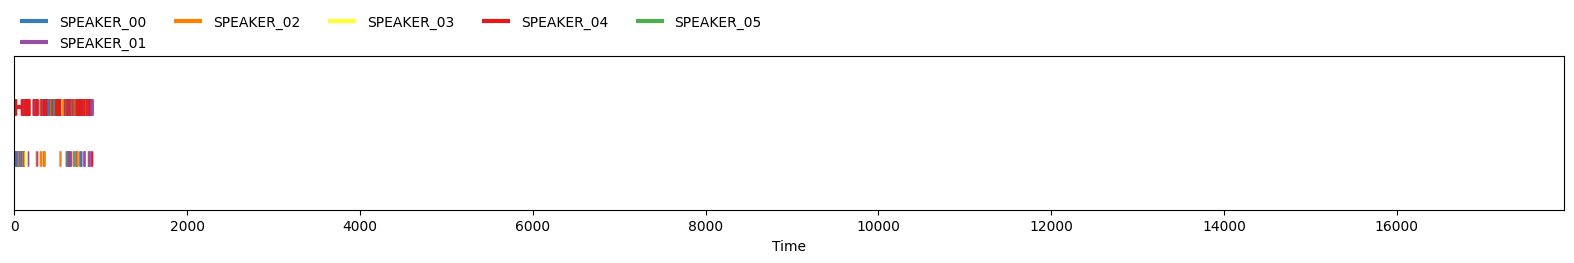

In [17]:
file_ex = {"audio": str(excerpt_path)}
diarization = pipeline(file_ex)
diarization


In [19]:
import pandas as pd

turns = []
for segment, _, speaker in diarization.itertracks(yield_label=True):
    turns.append({
        "recording_id": wav_path.stem,
        "excerpt_path": str(excerpt_path),
        "excerpt_start_sec": float(start_sec),
        "start_sec": float(segment.start) + float(start_sec),  # shift back to original timeline
        "end_sec": float(segment.end) + float(start_sec),
        "speaker_id": speaker,
        "duration_sec": float(segment.end - segment.start),
    })

turns_df = pd.DataFrame(turns).sort_values(["start_sec", "end_sec"]).reset_index(drop=True)
turns_df


,recording_id,excerpt_path,excerpt_start_sec,start_sec,end_sec,speaker_id,duration_sec
0,1739683525,/scratch/users/arunps/hindibabynet_tmp/1739683...,0.0,0.132219,1.482219,SPEAKER_04,1.350000
1,1739683525,/scratch/users/arunps/hindibabynet_tmp/1739683...,0.0,1.887219,4.485969,SPEAKER_04,2.598750
2,1739683525,/scratch/users/arunps/hindibabynet_tmp/1739683...,0.0,2.123469,2.275344,SPEAKER_00,0.151875
3,1739683525,/scratch/users/arunps/hindibabynet_tmp/1739683...,0.0,5.498469,19.133469,SPEAKER_04,13.635000
4,1739683525,/scratch/users/arunps/hindibabynet_tmp/1739683...,0.0,5.700969,5.970969,SPEAKER_00,0.270000
...,...,...,...,...,...,...,...
462,1739683525,/scratch/users/arunps/hindibabynet_tmp/1739683...,0.0,894.659094,895.519719,SPEAKER_01,0.860625
463,1739683525,/scratch/users/arunps/hindibabynet_tmp/1739683...,0.0,894.743469,895.654719,SPEAKER_04,0.911250
464,1739683525,/scratch/users/arunps/hindibabynet_tmp/1739683...,0.0,896.144094,896.751594,SPEAKER_01,0.607500
465,1739683525,/scratch/users/arunps/hindibabynet_tmp/1739683...,0.0,897.645969,898.219719,SPEAKER_01,0.573750
